In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

In [2]:
import wandb
from controller import Robot

from WebotsEnvironment import WebotsEnvironment
from WebotsGymEnv import WebotsGymEnv

env = WebotsEnvironment()
    
obs = env.reset()[0]
env.reset()

Error: only one Robot instance can be created per controller process.


array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [3]:
import math

import cv2
import numpy as np

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


In [4]:
def perspective_transform(image):
    height, width = image.shape[:2]
    
    src = np.float32([(0, height),
                        ((width * 0.25) + 50, height * 0.60),
                        ((width * 0.75) - 50, height * 0.60),
                        (width, height),])    # top-right
    
    dst = np.float32([(0, height),
                        (100, 100),
                        (width - 100, 100),
                        (width, height)])
    
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)

    # Apply the perspective transformation
    warped = cv2.warpPerspective(image, M, (width, height))

    return warped, M, M_inv

In [6]:
import math
import random

import cv2
import numpy as np

def pipeline(image, center_margin = 50):
    """
    An image processing pipeline which will output
    an image with the lane lines annotated.
    """
    
    height = image.shape[0]
    width = image.shape[1]

    region_of_interest_vertices = [
        (0, height),
        (width * 0.25, height * 0.60),
        (width * 0.75, height * 0.60),
        (width, height),
    ]

    cropped_image = region_of_interest(
        image,
        np.array(
            [region_of_interest_vertices],
            np.int32
        ),
    )

    upper_yellow = np.array([215, 220, 237])
    lower_yellow = np.array([80, 80, 208])

    mask = cv2.inRange(cropped_image, lower_yellow, upper_yellow)
    masked = cv2.bitwise_and(image, image , mask=mask)

    gray_image = cv2.cvtColor(masked, cv2.COLOR_RGB2GRAY)

    warped, M, M_inv = perspective_transform(gray_image)
    cannyed_image = cv2.Canny(warped, 850, 250, apertureSize=3)

    lines = cv2.HoughLinesP(cannyed_image, rho=2.5, theta=np.pi/180, threshold=15, minLineLength=20, maxLineGap=15)
        
    left_points = []
    right_points = []

    center = cannyed_image.shape[1] // 2
    

    left_weight = 0
    right_weight = 0

    def calc_weight(x):
        return abs(x - center)
    
    if lines is None:
        return left_weight,right_weight,left_points,right_points,cannyed_image,warped
    
    for line in lines:
        for x1, y1, x2, y2 in line:

            if abs(x1 - x2) > 5 and abs(x1 - x2) < 10:
                continue  # Skip vertical lines to avoid division by zero
            
            if x1 < center - center_margin :  # Left line
                left_points.append((x1, y1))
                left_weight += calc_weight(x1)
            if x2 < center - center_margin :  # Left line
                left_points.append((x2, y2))
                left_weight += calc_weight(x2)
            
            if x1 > center + center_margin :  # Left line
                right_points.append((x1, y1))
                right_weight += calc_weight(x1)
                
            if x2 > center + center_margin :  # Left line
                right_points.append((x2, y2))
                right_weight += calc_weight(x2)
                
    if len(right_points) > 0:
        right_weight = right_weight / len(right_points)

    if len(left_points) > 0:
        left_weight = left_weight / len(left_points)
         
    return left_weight,right_weight,left_points,right_points,cannyed_image,warped

In [9]:
def calculate_steering_angle(image_width, left_weight, right_weight):
    final_weight = right_weight - left_weight

    diff = image_width / 2
    angle = final_weight / diff
    return angle

In [8]:
radian = 0

In [27]:
import time

env.apply_action([0.2,radian])

env.robot.step(250)

camera = env.camera
img = np.array(camera.getImageArray(), dtype=np.uint8)

cv2_img = cv2.cvtColor(img.reshape((720,1280,3)) , cv2.COLOR_BGR2RGB)

In [28]:

height = cv2_img.shape[0]
width = cv2_img.shape[1]

center_margin = 10

region_of_interest_vertices = [
    (0, height),
    (width * 0.25, height * 0.60),
    (width * 0.75, height * 0.60),
    (width, height),
]

cropped_image = region_of_interest(
    cv2_img,
    np.array(
        [region_of_interest_vertices],
        np.int32
    ),
)

upper_yellow = np.array([215, 220, 237])
lower_yellow = np.array([80, 80, 208])

mask = cv2.inRange(cropped_image, lower_yellow, upper_yellow)
masked = cv2.bitwise_and(cv2_img, cv2_img , mask=mask)

gray_image = cv2.cvtColor(masked, cv2.COLOR_RGB2GRAY)

cannyed_image = cv2.Canny(gray_image, 850, 250, apertureSize=3)

lines = cv2.HoughLinesP(cannyed_image, rho=2.5, theta=np.pi/180, threshold=15, minLineLength=20, maxLineGap=15)
    
left_points = []
right_points = []

center = cannyed_image.shape[1] // 2


left_weight = 0
right_weight = 0

def calc_weight(x):
    return abs(x - center)

if lines is not None:
    for line in lines:
        for x1, y1, x2, y2 in line:

            if abs(x1 - x2) > 5 and abs(x1 - x2) < 10:
                continue  # Skip vertical lines to avoid division by zero
            
            if x1 < center - center_margin :  # Left line
                left_points.append((x1, y1))
                left_weight += calc_weight(x1)
            if x2 < center - center_margin :  # Left line
                left_points.append((x2, y2))
                left_weight += calc_weight(x2)
            
            if x1 > center + center_margin :  # Left line
                right_points.append((x1, y1))
                right_weight += calc_weight(x1)
                
            if x2 > center + center_margin :  # Left line
                right_points.append((x2, y2))
                right_weight += calc_weight(x2)
            
if len(right_points) > 0:
    right_weight = right_weight / len(right_points)

if len(left_points) > 0:
    left_weight = left_weight / len(left_points)

In [29]:
left_weight,right_weight

(0, 0)

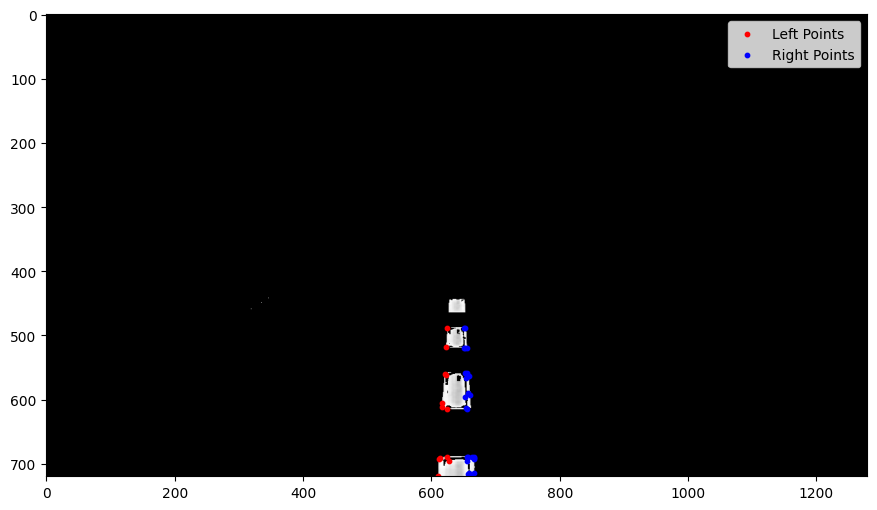

In [25]:
fig = plt.figure(figsize=(12,6))
# Plot the warped image with fitted lines and points
plt.imshow(gray_image, cmap='gray')

# Plot left and right points
left_y = [p[1] for p in left_points]
left_x = [p[0] for p in left_points]
right_y = [p[1] for p in right_points]
right_x = [p[0] for p in right_points]

plt.scatter(left_x, left_y, color='red', s=10, label='Left Points')
plt.scatter(right_x, right_y, color='blue', s=10, label='Right Points')

plt.legend()
plt.show()


In [ ]:
lines,warped,cropped_image,left_points,right_points = pipeline(cv2_img)

left_fit, right_fit = fit_lane_lines(left_points,right_points)

left_r_squared = evaluate_fit(left_points, left_fit)
right_r_squared = evaluate_fit(right_points, right_fit)

C:\Users\Saleh\AppData\Local\Temp\ipykernel_13828\1981450333.py:47: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (y2 - y1) / (x2 - x1)
C:\Users\Saleh\AppData\Local\Temp\ipykernel_13828\3827204249.py:4: RankWarning: Polyfit may be poorly conditioned
  right_fit = np.polyfit([p[1] for p in right_points], [p[0] for p in right_points], 2) if right_points else None


In [ ]:
height, width = cv2_img.shape[:2]
y_eval = height  # Evaluate at the bottom of the image

if left_fit is not None and right_fit is not None:
    left_x = np.polyval(left_fit, y_eval)
    right_x = np.polyval(right_fit, y_eval)
    lane_center = (left_x + right_x) / 2
elif left_fit is not None:
    lane_center = np.polyval(left_fit, y_eval)
elif right_fit is not None:
    lane_center = np.polyval(right_fit, y_eval)
else:
    lane_center = width / 2

# Calculate angle in radians
angle = np.arctan((lane_center - width / 2) / y_eval)

# Convert angle to degrees
angle_degrees = np.degrees(angle)

In [ ]:
steering_angle = calculate_steering_angle(cv2_img.shape[:2], left_fit if left_r_squared >= right_r_squared else None, 
                                                        right_fit if right_r_squared >= left_r_squared else None)
radian = steering_angle * (np.pi/180)

In [ ]:
radian,steering_angle

(0.3394705362364598, 19.450228995392024)

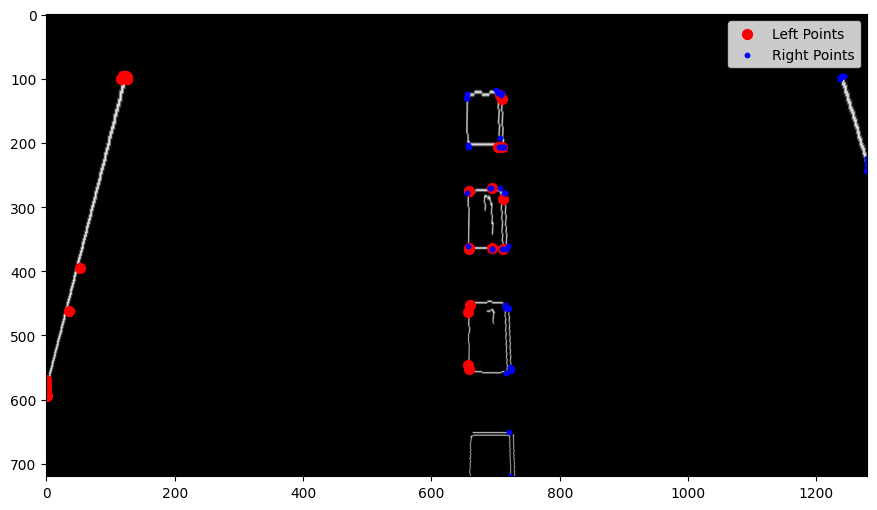

In [ ]:
warped_image = warped
fig = plt.figure(figsize=(12,6))
# Plot the warped image with fitted lines and points
plt.imshow(warped_image, cmap='gray')

# Plot left and right points
left_y = [p[1] for p in left_points]
left_x = [p[0] for p in left_points]
right_y = [p[1] for p in right_points]
right_x = [p[0] for p in right_points]

plt.scatter(left_x, left_y, color='red', s=50, label='Left Points')
plt.scatter(right_x, right_y, color='blue', s=10, label='Right Points')

plt.legend()
plt.show()


In [ ]:
all_lines = np.zeros(cv2_img.shape, dtype=np.uint8)

for line in lines:
    x1, y1, x2, y2 = line[0]
    green = random.randint(100 , 255)
    
    cv2.line(all_lines, (x1, y1), (x2, y2), (255, green, 0), 2)

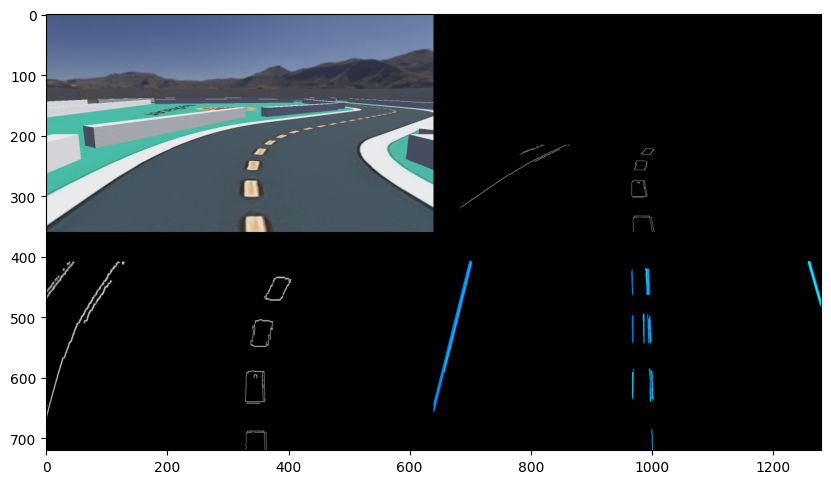

In [ ]:
_cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_GRAY2RGB)
_warped = cv2.cvtColor(warped, cv2.COLOR_GRAY2RGB)

height, width = cv2_img.shape[:2]

_image = cv2.resize(cv2_img, (width//2, height//2))
_img2 = cv2.resize(_cropped_image, (width//2, height//2))
_img3 = cv2.resize(_warped, (width//2, height//2))
_all_lines = cv2.resize(all_lines, (width//2, height//2))


top_row = np.hstack((_image, _img2))
bottom_row = np.hstack((_img3, _all_lines))
grid = np.vstack((top_row, bottom_row))

grid = cv2.cvtColor(grid, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 8))  # Adjust figsize as needed

plt.imshow(grid)